In [77]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import Cauchy, Morlet
from scipy import signal

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [78]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data + 10 *np.sin(2 * np.pi * 5 * t) #+ 50 * signal.square(2 * np.pi * 12.5 * t)
B2 = data + 40 *np.sin(2 * np.pi * 5 * t) #+ 10*signal.square(2 * np.pi * 12.5 * t)
B = np.vstack((B1,B2))
print(B.shape)

(2, 5000)


#### Create Transform Object and Analysis Filters

In [126]:
# Initializing the Transform object automatically forms the analysis and synthesis filter bank during __init__
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Cauchy(),
    pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
)

c:\Users\Alex\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:207: RuntimeWarning: divide by zero encountered in log
  im = plt.imshow(np.log(power), aspect='auto', origin='lower', extent=extent,


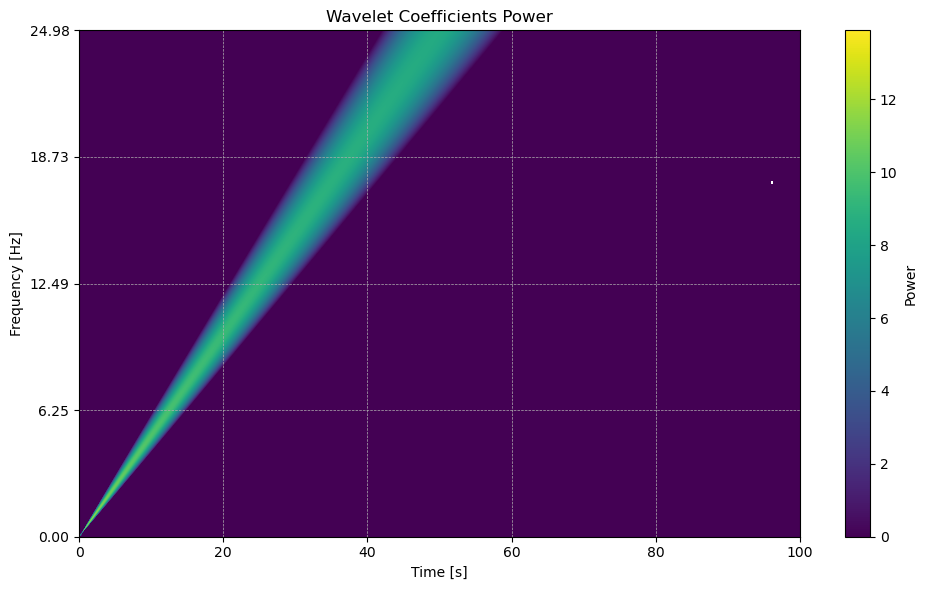

In [127]:
transform.power_scalogram(transform.Wfreq, vmin=0)

#### Transform


In [128]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

14.175873985468854
(2.839483323926139+0.062106596504502794j) (11.442311987182016+0.062106596504502794j) (4.0282674710880455-0.06623577759721633j)
(1250,)
(1250,)


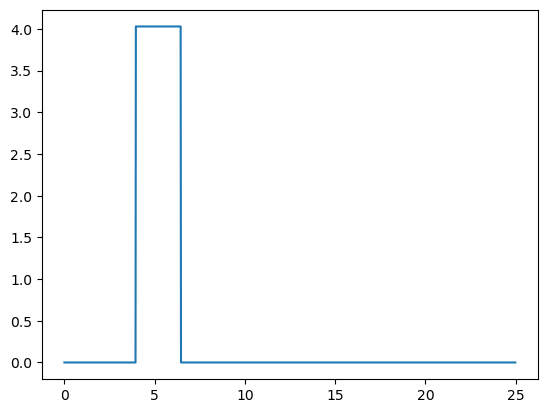

In [129]:
%matplotlib inline
sliced = slice(transform.pad_width, -1)
dw = (w2 - w1)

wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)

k_hat_real = np.where(
    np.abs(wc1) > np.percentile(np.abs(wc1), 90),
    np.abs((wc2)) / np.abs((wc1)),
    1e-5
)

w_clean = ((np.tile(k_hat_real,(w1.shape[-1],1)).T*w1)-w2)/(np.tile(k_hat_real,(w1.shape[-1],1)).T-1)
result = transform.inverse(np.copy(w_clean))
print(np.sqrt(((data-result)**2).mean(axis=0)))

plt.plot(transform.channel_freqs, k_hat_real)
print(np.max(wc1), np.max(wc2),np.max(wc2)/np.max(wc1))
print(transform.channel_freqs.shape)
print(k_hat_real.shape)



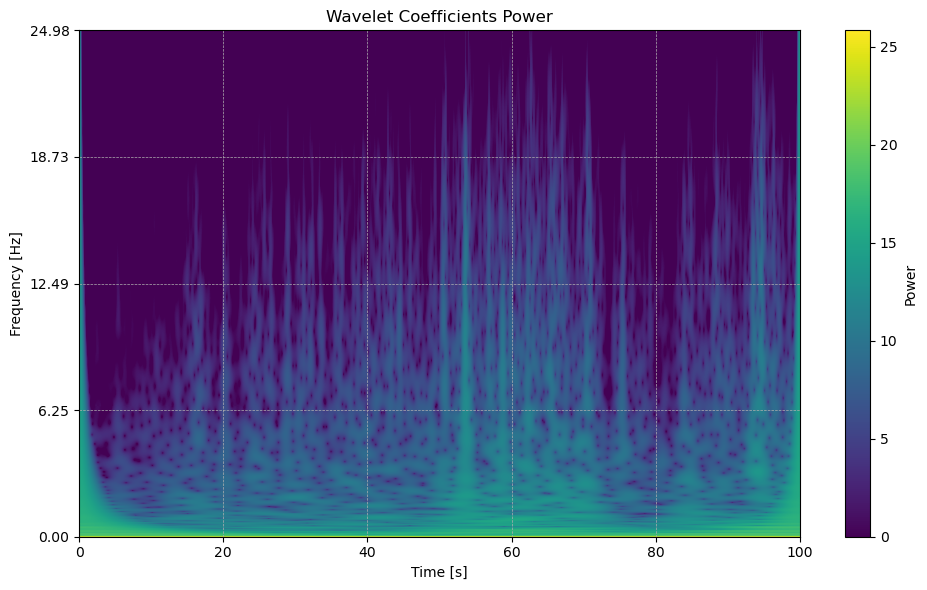

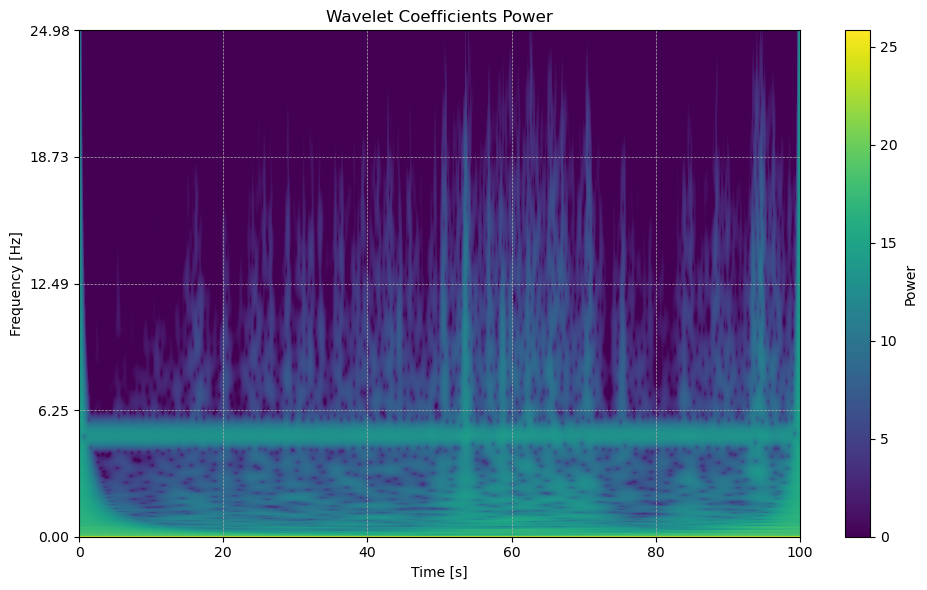

In [130]:
transform.power_scalogram(w_clean, vmin=0)
transform.power_scalogram(w1,vmin=0)

#### Compare to Normal WAICUP

(2.39509296724643+0j)


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


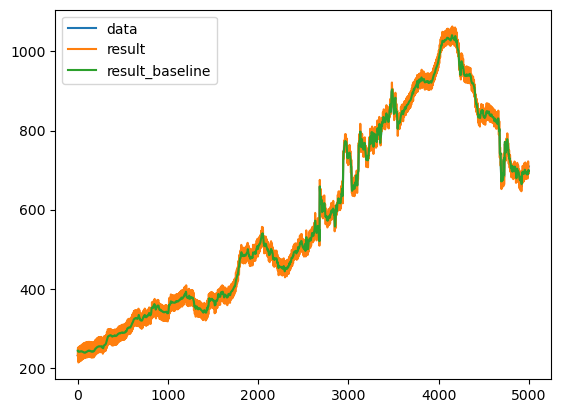

In [131]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result')
plt.plot(result_baseline, label='result_baseline')
plt.legend()

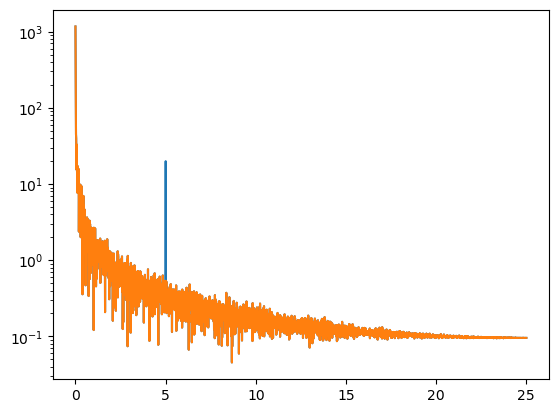

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


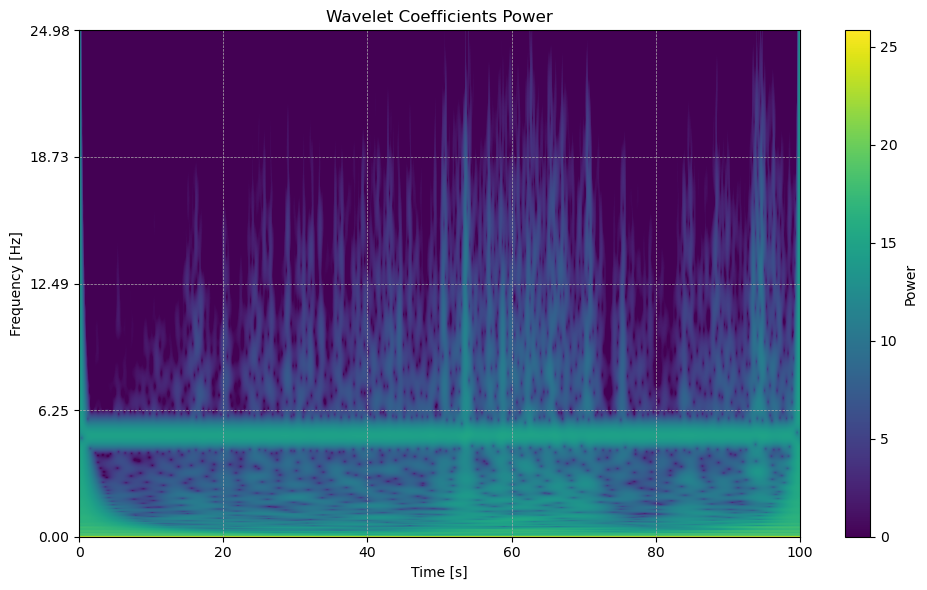

In [133]:
c = transform.forward(result)
transform.power_scalogram(c, vmin=0)

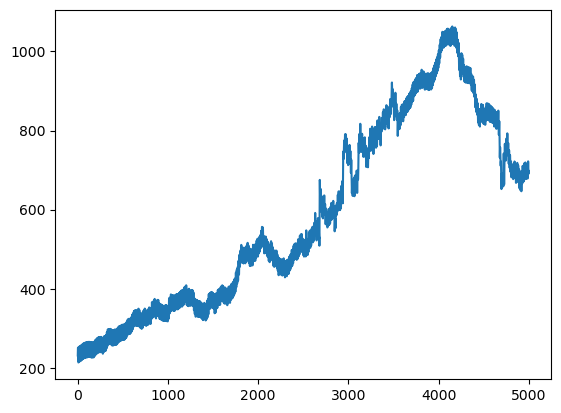

In [134]:
plt.plot(transform.inverse(c))

In [88]:
s_max = 10/(transform.N/transform.fs)
J = int(np.ceil(np.log2(s_max / (2 / transform.fs)) / transform.dj))
J

6

In [89]:
np.log2(s_max / (2 / transform.fs)) / transform.dj

5.28771237954945

In [90]:
np.log2(5000)


12.287712379549449